## 1. 이미지에서 텍스트 추출하기(easyOCR)

In [2]:
import easyocr
import numpy as np
import cv2
from typing import List, Dict

In [3]:
upload_image = 'test1.png'

In [4]:
reader = easyocr.Reader(['en'])
result = reader.readtext(upload_image)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [5]:
print(result)

[([[12, 14], [540, 14], [540, 87], [12, 87]], 'It was the best of', 0.9658043444948076), ([[7, 99], [686, 99], [686, 178], [7, 178]], 'times, it was the worst', 0.8693864604697936), ([[11, 181], [697, 181], [697, 267], [11, 267]], 'of times, it was the age', 0.7349637559231157), ([[11, 256], [649, 256], [649, 345], [11, 345]], 'of wisdom; it was the', 0.8425616344866556), ([[7, 344], [563, 344], [563, 433], [7, 433]], 'age of foolishness .', 0.8389083561447452)]


In [6]:
OCR_RESULTS = []
print("✅ Result : ")
for res in result:
    OCR_RESULTS.append(res[0:2])
    print(res[0:2])


✅ Result : 
([[12, 14], [540, 14], [540, 87], [12, 87]], 'It was the best of')
([[7, 99], [686, 99], [686, 178], [7, 178]], 'times, it was the worst')
([[11, 181], [697, 181], [697, 267], [11, 267]], 'of times, it was the age')
([[11, 256], [649, 256], [649, 345], [11, 345]], 'of wisdom; it was the')
([[7, 344], [563, 344], [563, 433], [7, 433]], 'age of foolishness .')


## 2. 추출된 텍스트 번역
- 추출된 각 텍스트 영역에서 문맥상 이어지면 전체 문장을 고려하여 번역을 수행하고 다시 각 영역에 적절하게 번역된 텍스트 분배

In [7]:
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOpenAI

In [8]:
source_lang = "en"
target_lang = "ko"

In [9]:
prompt_text = open("../../prompts/OCR_translate.yaml", "r", encoding="utf-8").read()
prompt = PromptTemplate(
        template=prompt_text,
        input_variables=["OCR_RESULTS","source_lang","target_lang"]
    )

llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)
chain = prompt | llm

llm_result = chain.invoke({
    "OCR_RESULTS": OCR_RESULTS,
    "source_lang": source_lang,
    "target_lang": target_lang}
    )

print(llm_result.content)

C:\Users\COM-PPJU\AppData\Local\Temp\ipykernel_17892\4100307702.py:7: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)


[([[12, 14], [540, 14], [540, 87], [12, 87]], '그것은 최고의 시기였다'), ([[7, 99], [686, 99], [686, 178], [7, 178]], '그것은 최악의 시기였다'), ([[11, 181], [697, 181], [697, 267], [11, 267]], '그것은 시대였다'), ([[11, 256], [649, 256], [649, 345], [11, 345]], '지혜의 시대였다; 그것은'), ([[7, 344], [563, 344], [563, 433], [7, 433]], '어리석음의 시대였다.')]


In [11]:
import ast

# 문자열을 Python 객체로 변환
translated_results = ast.literal_eval(llm_result.content)

for index, result in enumerate(translated_results):
    print(result)


([[12, 14], [540, 14], [540, 87], [12, 87]], '그것은 최고의 시기였다')
([[7, 99], [686, 99], [686, 178], [7, 178]], '그것은 최악의 시기였다')
([[11, 181], [697, 181], [697, 267], [11, 267]], '그것은 시대였다')
([[11, 256], [649, 256], [649, 345], [11, 345]], '지혜의 시대였다; 그것은')
([[7, 344], [563, 344], [563, 433], [7, 433]], '어리석음의 시대였다.')


## 3. 번역된 텍스트 융합 (fusing translated-text into the image)

In [12]:
! pip install Pillow opencv-python numpy

font_size :  50
font_size :  65
font_size :  75
font_size :  60
font_size :  60


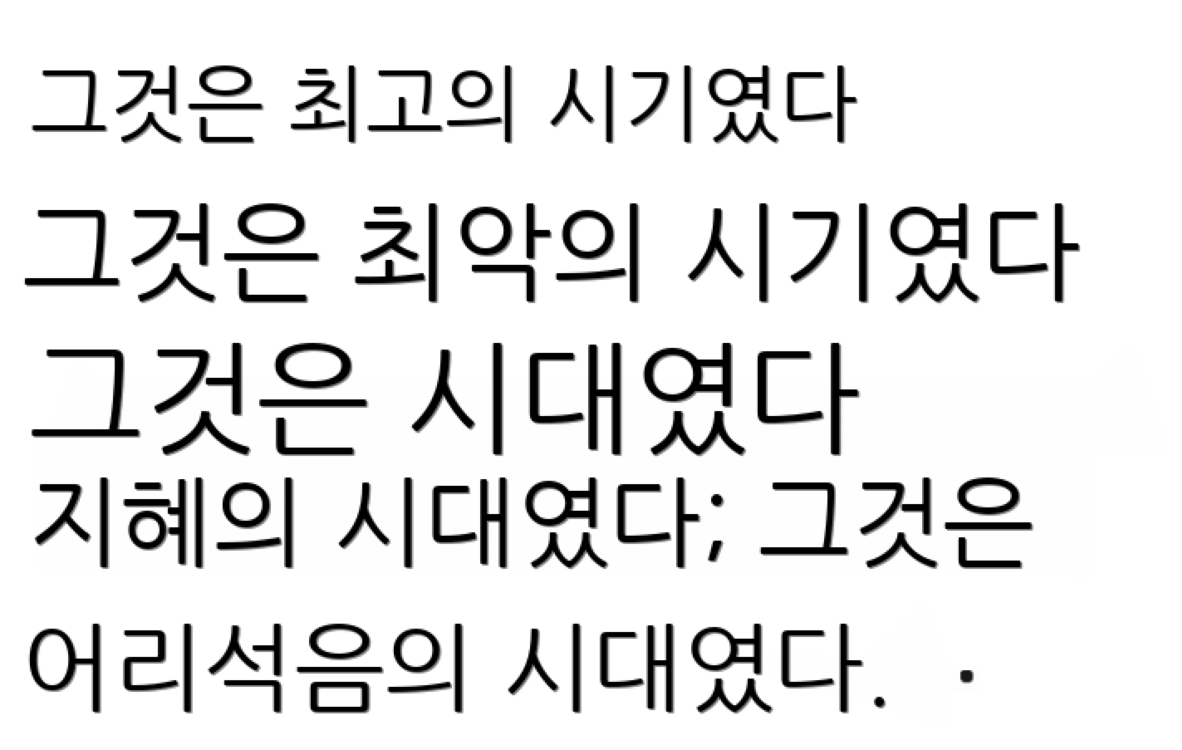

In [21]:
import cv2
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import ast

fontpath = r"C:\Users\COM-PPJU\AppData\Local\Microsoft\Windows\Fonts\NanumGothic.ttf"

def fit_text_to_box(text, box_width, box_height):
    """박스 크기에 맞게 폰트 크기를 조절하는 함수"""
    font_size = box_height
    font = ImageFont.truetype(fontpath, font_size)  # 한글 폰트 필요
    
    while font_size > 1:
        font = ImageFont.truetype(fontpath, font_size)
        text_bbox = font.getbbox(text)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        
        # 여백을 고려하여 약간 작은 크기로 조정 
        if text_width <= box_width * 0.95 and text_height <= box_height * 0.80:
            break
            
        font_size -= 1
    
    return font, 5 * round(font_size / 5)

def remove_text(image, bbox, margin=2):
    """텍스트 영역을 주변 색상으로 채우는 함수"""
    # 바운딩 박스 좌표
    x_coords = [p[0] for p in bbox]
    y_coords = [p[1] for p in bbox]
    x1, y1 = min(x_coords), min(y_coords)
    x2, y2 = max(x_coords), max(y_coords)
    
    # 마스크 생성
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    pts = np.array(bbox, np.int32)
    cv2.fillPoly(mask, [pts], 255)
    
    # 텍스트 영역 주변의 색상으로 채우기
    return cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)


def add_translated_text(image_path, translated_results, original_results):
    # 이미지 로드
    image = cv2.imread(image_path)
    
    # 먼저 모든 원본 텍스트 영역 제거
    for bbox, _ in original_results:
        image = remove_text(image, bbox)
    
    # OpenCV 이미지를 PIL 이미지로 변환
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(image_pil)
    
    # 번역된 텍스트 추가
    for bbox, translated_text in translated_results:
        # 박스 크기 계산
        x_coords = [p[0] for p in bbox]
        y_coords = [p[1] for p in bbox]
        box_width = max(x_coords) - min(x_coords)
        box_height = max(y_coords) - min(y_coords)
        
        # 텍스트 크기에 맞는 폰트 찾기
        font, font_size = fit_text_to_box(translated_text, box_width, box_height)
        print("font_size : ",font_size)
        
        # 텍스트 크기 측정
        text_bbox = font.getbbox(translated_text)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        
        # 텍스트 중앙 정렬 위치 계산
        x = min(x_coords)
        y = min(y_coords) + (box_height - text_height) // 2
        
        # 텍스트 그리기 (약간의 그림자 효과 추가)
        # 그림자
        draw.text((x+1, y+1), translated_text, font=font, fill=(128, 128, 128))
        # 메인 텍스트
        draw.text((x, y), translated_text, font=font, fill=(0, 0, 0))
    
    return image_pil

# 사용 예시
image_path = "./test1.png"
translated_results = ast.literal_eval(llm_result.content)
original_results = OCR_RESULTS  # 원본 OCR 결과
result_image = add_translated_text(image_path, translated_results, original_results)

# 결과 저장
result_image.save("translated_image2.png")

# matplotlib으로 결과 표시
plt.figure(figsize=(15, 10))
plt.imshow(result_image)
plt.axis('off')
plt.show()

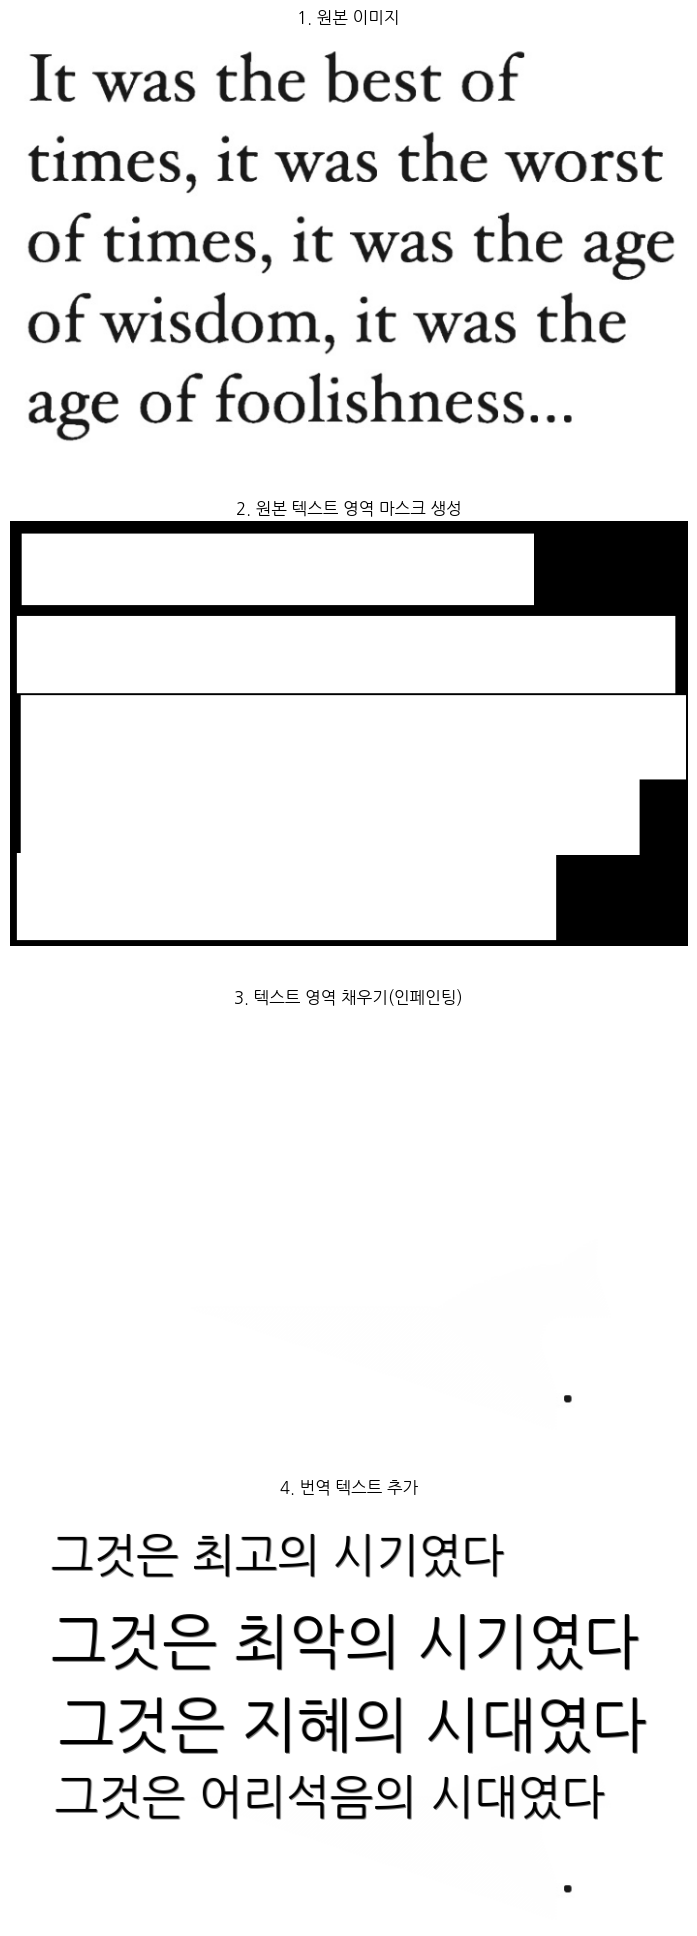

In [71]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def create_mask(image, bbox):
    """바운딩 박스 영역의 마스크 생성"""
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    pts = np.array(bbox, np.int32)
    cv2.fillPoly(mask, [pts], 255)
    return mask

fontpath = r"C:\Users\COM-PPJU\AppData\Local\Microsoft\Windows\Fonts\NanumGothic.ttf"

def process_image_with_steps(image_path, translated_results, original_results):
    # 1. 원본 이미지 로드
    original_image = cv2.imread(image_path)
    image = original_image.copy()
    
    # 2. 마스크 생성
    combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for bbox, _ in original_results:
        mask = create_mask(image, bbox)
        combined_mask = cv2.bitwise_or(combined_mask, mask)
    
    # 3. 텍스트 영역 제거된 이미지 생성
    masked_image = image.copy()
    masked_image[combined_mask == 255] = [255, 255, 255]  # 흰색으로 채우기
    
    # 4. 인페인팅으로 텍스트 영역 채우기
    inpainted_image = cv2.inpaint(image, combined_mask, 3, cv2.INPAINT_TELEA)
    
    # 5. 번역된 텍스트 추가
    translated_image = Image.fromarray(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(translated_image)
    
    for bbox, translated_text in translated_results:
        # 박스 크기 계산
        x_coords = [p[0] for p in bbox]
        y_coords = [p[1] for p in bbox]
        box_width = max(x_coords) - min(x_coords)
        box_height = max(y_coords) - min(y_coords)
        
        # 텍스트 크기에 맞는 폰트 찾기
        font_size = min(box_height, 100)  # 초기 폰트 크기
        font = ImageFont.truetype(fontpath, font_size)
        
        # 폰트 크기 조정
        while font_size > 1:
            font = ImageFont.truetype(fontpath, font_size)
            text_bbox = font.getbbox(translated_text)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            if text_width <= box_width * 0.95 and text_height <= box_height * 0.95:
                break
            font_size -= 1
        
        # 텍스트 위치 계산
        x = min(x_coords) + (box_width - text_width) // 2
        y = min(y_coords) + (box_height - text_height) // 2
        
        # 텍스트 그리기
        draw.text((x+1, y+1), translated_text, font=font, fill=(128, 128, 128))  # 그림자
        draw.text((x, y), translated_text, font=font, fill=(0, 0, 0))  # 메인 텍스트
    
    # 모든 이미지를 RGB로 변환
    original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    masked_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
    inpainted_rgb = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)
    
    # matplotlib 폰트 설정
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 폰트 추가
    fm.fontManager.addfont(fontpath)
    plt.rcParams['font.family'] = 'NanumGothic'

    # 결과 시각화
    plt.figure(figsize=(10,20))
    
    plt.subplot(411)
    plt.title('1. 원본 이미지', fontsize=12)
    plt.imshow(original_rgb)
    plt.axis('off')
    
    plt.subplot(412)
    plt.title('2. 원본 텍스트 영역 마스크 생성', fontsize=12)
    plt.imshow(combined_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(413)
    plt.title('3. 텍스트 영역 채우기(인페인팅)', fontsize=12)
    plt.imshow(inpainted_rgb)
    plt.axis('off')
    
    plt.subplot(414)
    plt.title('4. 번역 텍스트 추가', fontsize=12)
    plt.imshow(translated_image)
    plt.axis('off')
    
    plt.tight_layout(pad=3.0) 
    plt.show()
    
    return translated_image

# 사용 예시
image_path = "./test1.png"
translated_results = ast.literal_eval(llm_result.content)
result_image = process_image_with_steps(image_path, translated_results, OCR_RESULTS)

# 결과 저장
result_image.save("translated_image2.png")

In [72]:
upload_image = 'test2.jpg'

In [73]:
reader = easyocr.Reader(['en','ko']) # 읽고 싶은 언어만 설정
result = reader.readtext(upload_image)
print(result)
OCR_RESULTS = []
print("✅ Result : ")
for res in result:
    OCR_RESULTS.append(res[0:2])
    print(res[0:2])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[53, 13], [95, 13], [95, 33], [53, 33]], '타고', 0.9997480554364656), ([[58, 32], [92, 32], [92, 40], [58, 40]], 'arodki', 0.3791796332205188), ([[384, 14], [502, 14], [502, 44], [384, 44]], '1개월 단위로', 0.9700136254547718), ([[326, 40], [502, 40], [502, 70], [326, 70]], '전기차가 필요할 때!', 0.9603615808307685), ([[356, 70], [501, 70], [501, 110], [356, 110]], '타고 월렌트', 0.8489464132429355), ([[339, 117], [497, 117], [497, 133], [339, 133]], '070-5067-3100 / wWW tagokr', 0.6976330150153751)]
✅ Result : 
([[53, 13], [95, 13], [95, 33], [53, 33]], '타고')
([[58, 32], [92, 32], [92, 40], [58, 40]], 'arodki')
([[384, 14], [502, 14], [502, 44], [384, 44]], '1개월 단위로')
([[326, 40], [502, 40], [502, 70], [326, 70]], '전기차가 필요할 때!')
([[356, 70], [501, 70], [501, 110], [356, 110]], '타고 월렌트')
([[339, 117], [497, 117], [497, 133], [339, 133]], '070-5067-3100 / wWW tagokr')


In [74]:
source_lang = "ko"
target_lang = "en"

In [75]:
llm_result = chain.invoke({
    "OCR_RESULTS": OCR_RESULTS,
    "source_lang": source_lang,
    "target_lang": target_lang}
    )


translated_results = ast.literal_eval(llm_result.content)

for index, result in enumerate(translated_results):
    print(result)

([[53, 13], [95, 13], [95, 33], [53, 33]], 'Tago')
([[58, 32], [92, 32], [92, 40], [58, 40]], 'arodki')
([[384, 14], [502, 14], [502, 44], [384, 44]], 'Monthly basis')
([[326, 40], [502, 40], [502, 70], [326, 70]], 'When you need an electric car!')
([[356, 70], [501, 70], [501, 110], [356, 110]], 'Tago Monthly Rent')
([[339, 117], [497, 117], [497, 133], [339, 133]], '070-5067-3100 / www.tagokr')


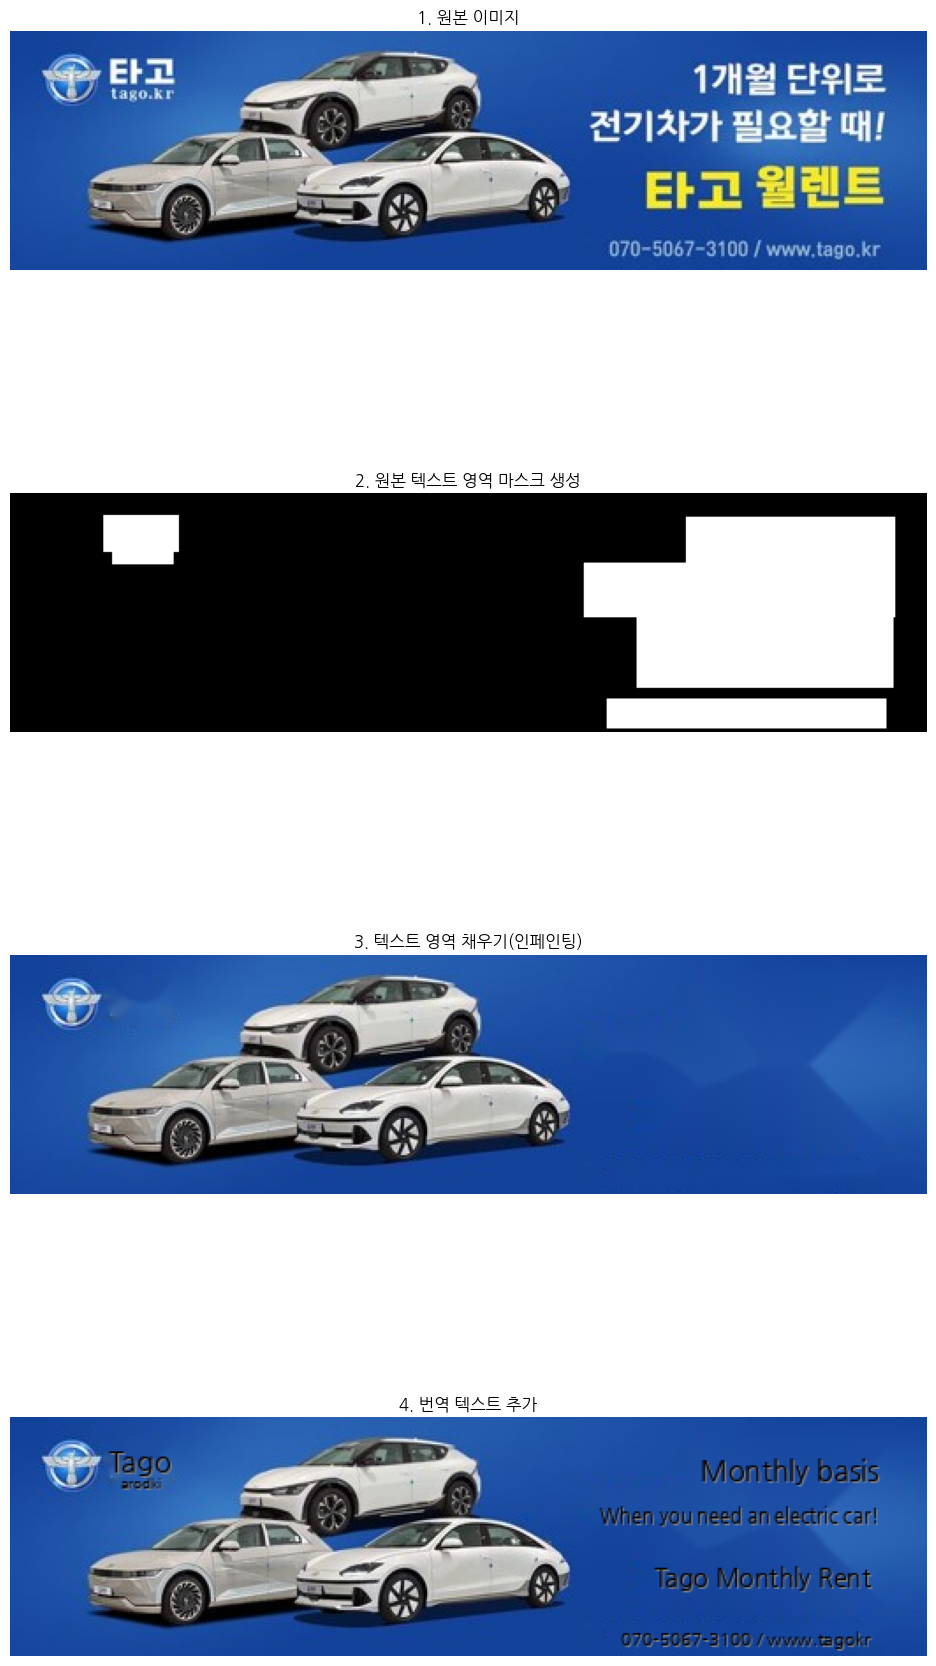

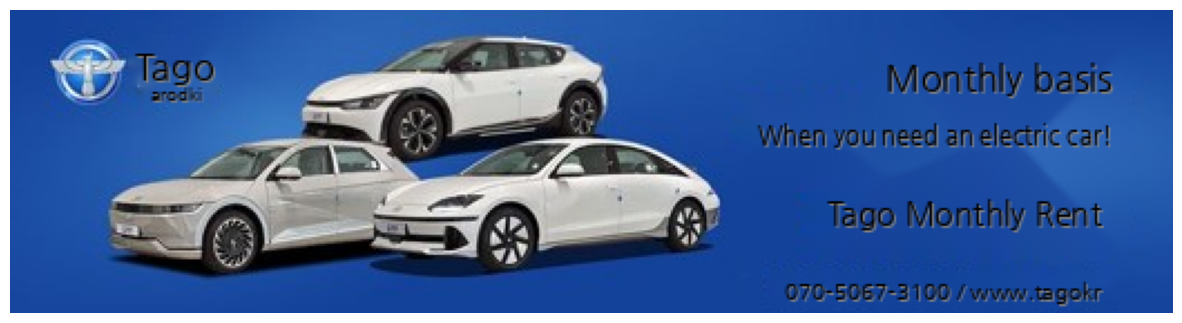

In [ ]:
result_image = process_image_with_steps(upload_image, translated_results, OCR_RESULTS)

result_image.save("translated_image3.png")